# 딥러닝

## 대표적 심층 신경망의 종류와 용도
- CNN(Convolutional Neural Network) : 합성곱 신경망
    - 3차원 데이터의 공간적 정보를 유지한 채 다음 층으로 보냄
    - 영상인식, 컴퓨터 비전
- RNN(Recurrent Neural Network) : 순환 신경망
    - 순차적 정보 : 음악, 텍스트, 작사, 작곡, 번역, 주가 등
    - 음석인식
- DBN(Deep Belief Network) : 딥비리프망
    - 글씨와 음성인식
- GAN(Generative Adversarial Network) : 적대적 신경망(유망)
    - 영상과 음성의 복원
 

# 합성곱 신경망

## 합성곱 신경망(CNN : Convolutional Neural Network)
- 이미지 분류에 주로 사용
- 가장 유용한 특성을 자동으로 학습
- 특성 계층 학습
    - 입력층에 가까운 층은 저수준 특성(대략적 모양)을 추출
    - 뒤로 갈수록 고수준의 특성(복잡한 모양과 패턴)을 추출
    - 저수준 특성을 연결하여 고수준의 특성을 만들어 특성 계층을 구성
    - 맨 뒤쪽 층은 완전연결층으로 분류나 예측
- CNN의 특징
    - 입력 이미지로부터 특성맵(feature map)을 생성
    - 희소연결
        - 특성맵의 각 원소는 이미지의 국부적 픽셀 패치에서 유도
        - 모든 입력 이미지가 뉴런에 연결되지는 않음
    - 파라미터 공유
- 전형적인 CNN 아키텍처
    - 여러 개의 합성곱(conv)층과 풀링(pooling)층(=서브샘플링층)으로 이루어짐
        - 풀링층 : 가중치가 없음
    - 마지막에는 하나 이상의 완전연결(FC)층  
<img src = 'https://wikidocs.net/images/page/41039/3.gif' width = 400/>

## 2D 합성곱(convolution)
- 2D 이산 합성곱
    - <img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbVThNn%2FbtrlyiUYH5x%2FKdE6JEcIiC5oGrw651Ieu0%2Fimg.png' width = 600/>  
- <img src = 'https://wikidocs.net/images/page/41039/4.png' width = 800/>
- 패딩(padding)
    - 입력 데이터의 외곽에 지정된 픽셀만큼 특정 값(보통 0)으로 채워 넣은 것
    - 필터와 스트라이드로 인해 특성맵의 크기가 입력데이터보다 줄어드는 것을 방지
- 스트라이드(stride) : 필터를 순회하는 간격
- <img src = 'https://wikidocs.net/images/page/41039/5.gif' width = 700/>

## 서브샘플링(풀링)
- 최대 풀링(max-pooling) vs 평균 풀링(average-pooling)
- ex) 최대풀링
<img src = 'https://wikidocs.net/images/page/41039/7.png' width = 500/>
- 풀링의 장점
    - 잡음(noise) 혹은 국부적 변화에 영향을 덜 받음
    - 특성 크기를 줄여 계산 효율성을 높임
    - 스트라이드와 비슷한 효과, 하지만 학습 가중치가 없음
    

## 드롭아웃(dropout)
- 네트워크의 크기 결정은 어려움 문제임
    - 작은 네트워크는 과소적합, 너무 큰 네트워크는 과대적합ㅇ르 유발
- 드롭아웃
    - 훈련 시 정방향 계산에서 은닉 유닛의 일부를 정해진 확률(보통 .5)로 랜덤하게 드롭아웃(가중치의 비활성화)
    - 평가(추론) 단계에서는 모든 은닉 유닛을 다시 활성화 함
    - 과대적합 방지

# MNIST 데이터를 위한 CNN

## 데이터 적재와 전처리
- tensorflow_datasets 모듈로 데이터셋 적재

In [2]:
import tensorflow_datasets as tfds

mnist_builder = tfds.builder('mnist')
mnist_builder.download_and_prepare()
datasets = mnist_builder.as_dataset(shuffle_files = False)
datasets  # 28, 28, 1(1 = channel)  # 훈련/테스트 셋으로 분할되어 있음

{'train': <PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 'test': <PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>}

In [4]:
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

- 데이터셋 전처리 : 표준화

In [10]:
import tensorflow as tf

mnist_train = mnist_train_orig.map(lambda item : (tf.cast(item['image'], tf.float32)/255.0, 
                                                 tf.cast(item['label'], tf.int32)))
mnist_test = mnist_test_orig.map(lambda item : (tf.cast(item['image'], tf.float32)/255.0, 
                                                 tf.cast(item['label'], tf.int32)))

- 훈련/검증 데이터셋 만들기

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size = BUFFER_SIZE, reshuffle_each_iteration = False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

## CNN 아키텍쳐
- 합성곱1 -> 풀링1 -> 합성곱2 -> 풀링2 -> Flatten -> 완전연결1 -> 완전연결2  
                                           -> 여기서부턴 MLP랑 비슷
- 각 층의 텐서차원
    - 입력 : [batch * 28 * 28 * 1] (흑백이므로 채널 수 = 1)
    - 합성곱1 : [batch * 24 * 24 * 32] (필터(커널) 수 = 32)
    - 풀링1 : [batch * 12 * 12 * 32] (풀 사이즈 = (2, 2))
    - 합성곱2 : [batch * 8 * 8 * 64] (필터(커널) 수 = 64)
    - 풀링2 : [batch * 4 * 4 * 64] (풀 사이즈 = (2, 2))
    - 완전연걸1 : [batch * 1024] (뉴런의 수 = 1024)
    - 완전연결과 소프트맥스 층 : [batch * 10] (클래스의 수 = 10]
    - ![ㅡ](https://gaussian37.github.io/assets/img/dl/concept/what-is-cnn/Image-Architecture-of-Convolutional-Neural-Network.png)

- CNN 구축

In [15]:
cnn = tf.keras.Sequential()
# 특성계층학습
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5),  # filters와 kernel은 같은 의미
                               strides = (1, 1), padding = 'same',  # 28x28 -> 28x28(특성 맵의 크기를 유지)
                               data_format = 'channels_last',
                               name = 'conv_1', activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2), name = 'pool_1'))
cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (5, 5),  # filters와 kernel은 같은 의미
                               strides = (1, 1), padding = 'same',  # 28x28 -> 28x28
                               data_format = 'channels_last',
                               name = 'conv_2', activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2), name = 'pool_2'))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units = 1024, name = 'fc_1', activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(rate = 0.5))  # dropout
cnn.add(tf.keras.layers.Dense(units = 10, name = 'fc_2', activation = 'softmax'))

- CNN 훈련

In [16]:
cnn.build(input_shape = (None, 28, 28, 1))  # 지연된 연산 : input_shape를 모델 구축할 때 넣는 것이 아니라 나중에 넣는 것
cnn.compile(optimizer = tf.keras.optimizers.Adam(),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics = ['accuracy'])
NUM_EPOCHS = 20
history = cnn.fit(mnist_train, epochs = NUM_EPOCHS, 
                 validation_data = mnist_valid, shuffle = True)

Epoch 1/20
782/782 [==============================] - 59s 73ms/step - loss: 0.1399 - accuracy: 0.9563 - val_loss: 0.0492 - val_accuracy: 0.9852
Epoch 2/20
782/782 [==============================] - 61s 77ms/step - loss: 0.0445 - accuracy: 0.9864 - val_loss: 0.0412 - val_accuracy: 0.9874
Epoch 3/20
782/782 [==============================] - 60s 77ms/step - loss: 0.0299 - accuracy: 0.9907 - val_loss: 0.0356 - val_accuracy: 0.9894
Epoch 4/20
782/782 [==============================] - 60s 76ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.0403 - val_accuracy: 0.9877
Epoch 5/20
782/782 [==============================] - 60s 76ms/step - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.0395 - val_accuracy: 0.9894
Epoch 6/20
782/782 [==============================] - 59s 75ms/step - loss: 0.0160 - accuracy: 0.9948 - val_loss: 0.0376 - val_accuracy: 0.9906
Epoch 7/20
782/782 [==============================] - 59s 75ms/step - loss: 0.0126 - accuracy: 0.9959 - val_loss: 0.0483 - val_accuracy:

- 학습곡선

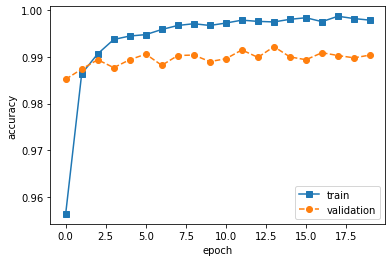

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], 's', linestyle = '-', label = 'train')
plt.plot(history.history['val_accuracy'], 'o', linestyle = '--', label = 'validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

- CNN 평가

In [18]:
cnn.evaluate(mnist_test.batch(20))

500/500 [==============================] - 4s 8ms/step - loss: 0.0441 - accuracy: 0.9921


[0.0440712571144104, 0.9921000003814697]

- 예측

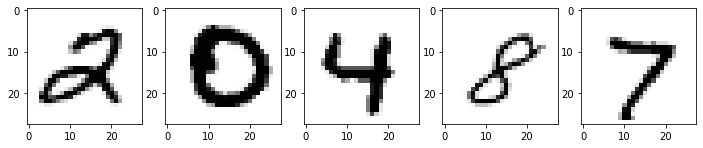

In [19]:
batch_test = next(iter(mnist_test.batch(5)))
plt.figure(figsize = (12, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch_test[0][i, :, :, 0], cmap = 'Greys')

In [20]:
preds = cnn(batch_test[0])
pred_classes = tf.argmax(preds, axis = 1)
pred_classes

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([2, 0, 4, 8, 7], dtype=int64)>